In [82]:
import io
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve,plot_roc_curve
import math
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

In [83]:
plt.rcParams['figure.figsize']  = (16, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

In [84]:
plt.ion()
plt.style.use('seaborn-colorblind')

In [85]:
conn = sqlite3.connect('sql/sql.db')
cursor = conn.cursor()

In [86]:
#Executar só uma vez a cada vez que abrir o colab
f = io.open('sql/trabalho.sql', 'r', encoding='ISO-8859-1')
sql = f.read()
cursor.executescript(sql)

OperationalError: table ANSWERS already exists

Modelo relacional
<img src="diagrama/diagrama.png">

In [87]:
def boostreap(p,n_size = 500):
    values = np.zeros(n_size)
    
    d = pd.DataFrame(p)
    
    for i in range(n_size):
        sample = d[0].sample(replace = True,n = len(p))
        values[i] = sample.mean()
        
    return values

# Valores

In [120]:
query = """
Select *
From Religion Natural join PESOS NATURAL JOIN ANSWERS NATURAL JOIN SIZE NATURAL JOIN IDH NATURAL JOIN CULTURE 
WHERE SUBSET == TIPO

"""

df = pd.read_sql_query(query,conn)

df["Religiosity"] = 100 -(df["NonBeliever"] + df["Atheist"])
df["NonAtheist"] = 100 - df["Atheist"]
df["ReligiousAndAtheists"] = 100 - df["NonBeliever"]

df = df.drop(['Catholic', 'Orthodox', 'Protestant', 'OtherChristian',
       'TotalChristians', 'NonBeliever', 'Atheist', 'Muslim'],1)

df["TAMANHO"] = df["PERCENTAGE"] * df["VALOR"] * 0.01
df

,COUNTRYCODE,QC,ANSWER,VALUE,SUBSET,PERCENTAGE,NOTES,TIPO,VALOR,HDI,...,pdi,idv,mas,uai,ltowvs,ivr,Religiosity,NonAtheist,ReligiousAndAtheists,TAMANHO
0,0,e1,Yes,0.0,LESBIAN,33,NULL,LESBIAN,437,885.0,...,11.0,55.0,79.0,70.0,60.0,63,80.5,95.9,84.6,144.21
1,0,e1,No,1.0,LESBIAN,53,NULL,LESBIAN,437,885.0,...,11.0,55.0,79.0,70.0,60.0,63,80.5,95.9,84.6,231.61
2,0,e1,Don`t know,0.5,LESBIAN,2,[0],LESBIAN,437,885.0,...,11.0,55.0,79.0,70.0,60.0,63,80.5,95.9,84.6,8.74
3,0,e1,Yes,0.0,GAY,51,NULL,GAY,1558,885.0,...,11.0,55.0,79.0,70.0,60.0,63,80.5,95.9,84.6,794.58
4,0,e1,No,1.0,GAY,25,NULL,GAY,1558,885.0,...,11.0,55.0,79.0,70.0,60.0,63,80.5,95.9,84.6,389.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4503,27,fb2_6,More perpetrators,0.0,BIM,83,[0],BIM,61,844.0,...,100.0,52.0,100.0,51.0,77.0,28,87.6,92.6,95.0,50.63
4504,27,fb2_6,Don`t know,0.5,BIM,0,[0],BIM,61,844.0,...,100.0,52.0,100.0,51.0,77.0,28,87.6,92.6,95.0,0.00
4505,27,fb2_6,Alone,1.0,TRANS,27,[0],TRANS,115,844.0,...,100.0,52.0,100.0,51.0,77.0,28,87.6,92.6,95.0,31.05
4506,27,fb2_6,More perpetrators,0.0,TRANS,70,NULL,TRANS,115,844.0,...,100.0,52.0,100.0,51.0,77.0,28,87.6,92.6,95.0,80.50


In [121]:
subset = df["SUBSET"].unique()
country = df["COUNTRYCODE"].unique()

In [122]:
col = ["SUBSET","COUNTRYCODE"]

for i in df.columns[9:]:
    col.append(i)
    
col.append("value")

In [123]:
query = """
Select *
From Size

"""

tamanho = pd.read_sql_query(query,conn)
tamanho

,COUNTRYCODE,TIPO,VALOR
0,0,LESBIAN,437
1,0,GAY,1558
2,0,BIW,164
3,0,BIM,217
4,0,TRANS,167
...,...,...,...
135,13,LESBIAN,235
136,13,GAY,592
137,13,BIW,157
138,13,BIM,105


In [129]:
def gerarB(selecionados,df,n_size=500):
    p = np.zeros(0)
    for country in selecionados:
        pais = df[df["COUNTRYCODE"] == country]

        for x in range(pais.shape[0]):
            sample = pais.iloc[x]
            
            new = np.ones(int(sample["TAMANHO"])) * sample["VALUE"]
            
            p = np.concatenate((p,new))
            
            
    b = boostreap(p,n_size=n_size)
    
    return b

In [160]:
values = pd.DataFrame(columns=col)
for i in subset:
    sample1 = df[df["SUBSET"] == i]
    
    for j in country:
        sample = sample1[sample1["COUNTRYCODE"] == j]
        
        if len(sample) == 0:
            continue
        
        final = [i,j]
        
        for u in sample.iloc[0].values[9:]:
            final.append(u)
            
        
        bot = gerarB([j],sample,n_size=20)     
        
        for u in bot:
        
            final.append(u)

            new = pd.DataFrame([final],columns=col)

            values = values.append(new,ignore_index=True)
            
            final = final[:-1]

values.drop("TAMANHO",1)
values

,SUBSET,COUNTRYCODE,HDI,LEB,EYS,MYS,GNI,GNI_HDI,pdi,idv,mas,uai,ltowvs,ivr,Religiosity,NonAtheist,ReligiousAndAtheists,TAMANHO,value
0,LESBIAN,0,885.0,81.4,15.7,10.8,43.869,-5.0,11.0,55.0,79.0,70.0,60.0,63,80.5,95.9,84.6,144.21,0.363502
1,LESBIAN,0,885.0,81.4,15.7,10.8,43.869,-5.0,11.0,55.0,79.0,70.0,60.0,63,80.5,95.9,84.6,144.21,0.369231
2,LESBIAN,0,885.0,81.4,15.7,10.8,43.869,-5.0,11.0,55.0,79.0,70.0,60.0,63,80.5,95.9,84.6,144.21,0.359738
3,LESBIAN,0,885.0,81.4,15.7,10.8,43.869,-5.0,11.0,55.0,79.0,70.0,60.0,63,80.5,95.9,84.6,144.21,0.357283
4,LESBIAN,0,885.0,81.4,15.7,10.8,43.869,-5.0,11.0,55.0,79.0,70.0,60.0,63,80.5,95.9,84.6,144.21,0.360884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,TRANS,27,844.0,76.3,15.1,12.2,25.845,5.0,100.0,52.0,100.0,51.0,77.0,28,87.6,92.6,95.0,65.55,0.298253
2596,TRANS,27,844.0,76.3,15.1,12.2,25.845,5.0,100.0,52.0,100.0,51.0,77.0,28,87.6,92.6,95.0,65.55,0.301430
2597,TRANS,27,844.0,76.3,15.1,12.2,25.845,5.0,100.0,52.0,100.0,51.0,77.0,28,87.6,92.6,95.0,65.55,0.290707
2598,TRANS,27,844.0,76.3,15.1,12.2,25.845,5.0,100.0,52.0,100.0,51.0,77.0,28,87.6,92.6,95.0,65.55,0.308975


In [161]:
df_final = values

df_final.fillna(0,inplace=True)
df_final

,SUBSET,COUNTRYCODE,HDI,LEB,EYS,MYS,GNI,GNI_HDI,pdi,idv,mas,uai,ltowvs,ivr,Religiosity,NonAtheist,ReligiousAndAtheists,TAMANHO,value
0,LESBIAN,0,885.0,81.4,15.7,10.8,43.869,-5.0,11.0,55.0,79.0,70.0,60.0,63,80.5,95.9,84.6,144.21,0.363502
1,LESBIAN,0,885.0,81.4,15.7,10.8,43.869,-5.0,11.0,55.0,79.0,70.0,60.0,63,80.5,95.9,84.6,144.21,0.369231
2,LESBIAN,0,885.0,81.4,15.7,10.8,43.869,-5.0,11.0,55.0,79.0,70.0,60.0,63,80.5,95.9,84.6,144.21,0.359738
3,LESBIAN,0,885.0,81.4,15.7,10.8,43.869,-5.0,11.0,55.0,79.0,70.0,60.0,63,80.5,95.9,84.6,144.21,0.357283
4,LESBIAN,0,885.0,81.4,15.7,10.8,43.869,-5.0,11.0,55.0,79.0,70.0,60.0,63,80.5,95.9,84.6,144.21,0.360884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2595,TRANS,27,844.0,76.3,15.1,12.2,25.845,5.0,100.0,52.0,100.0,51.0,77.0,28,87.6,92.6,95.0,65.55,0.298253
2596,TRANS,27,844.0,76.3,15.1,12.2,25.845,5.0,100.0,52.0,100.0,51.0,77.0,28,87.6,92.6,95.0,65.55,0.301430
2597,TRANS,27,844.0,76.3,15.1,12.2,25.845,5.0,100.0,52.0,100.0,51.0,77.0,28,87.6,92.6,95.0,65.55,0.290707
2598,TRANS,27,844.0,76.3,15.1,12.2,25.845,5.0,100.0,52.0,100.0,51.0,77.0,28,87.6,92.6,95.0,65.55,0.308975


In [165]:
def train(df,sep):
    df_final = df.copy() 
    df_final = df_final[df_final["SUBSET"] == sep]   
    
    df_final = df_final.drop("SUBSET",1)
    df_final = df_final.drop("TAMANHO",1)
    df_final = df_final.drop("COUNTRYCODE",1)
    
    X = df_final.drop("value",1)
    y = df_final["value"]
    
    X, X_val, y, y_val = train_test_split(X, y, test_size=0.2)
    
    X_mean = X.mean()
    X_std = X.std()
    y_mean = y.mean()
    y_std = y.std()
    
    
    X_val = X_val - X_mean
    X_val = X_val / X.std()
    X = X - X.mean()
    X = X / X.std()
    
    parameters = {}
    svs = LinearRegression()
    cv = KFold(n_splits=5,shuffle=True)
    clf = GridSearchCV(svs,parameters,cv = cv)
    
    clf.fit(X,y)
    
    best = clf.best_estimator_
    
    comparacao = pd.DataFrame(columns=["COUNTRYCODE","Value","Tipo"])
    
    df = df.drop('TAMANHO',1)
    for i in df.values:        
        country = i[1]
        original = i[-1]
        
        novos = i[2:-1] - X_mean
        novos = novos / X_std
        novos = novos.values
        novos = np.array(novos,dtype=float)
        
        
        pred = best.predict([novos])
        
        comparacao = comparacao.append({"COUNTRYCODE": country,
                          "Value": original,
                          "Tipo": "original"},ignore_index=True)
        
        comparacao = comparacao.append({"COUNTRYCODE": country,
                          "Value": pred[0],
                          "Tipo": "predito"},ignore_index=True)

    print("Coeficientes: ")
    
    u = 0
    for i in best.coef_:
        print("{}: {:.4f}".format(X.columns[u],i))
        u += 1
        
    print("Mean_squared_error : {:.4f}".format(mean_squared_error(y_val,best.predict(X_val))))
    
    print("R_score: {:.4f}".format(r2_score(y_val,best.predict(X_val))))
    
    return [best,comparacao]

In [166]:
query = """
Select *
From Country

"""

conv = pd.read_sql_query(query,conn)

Coeficientes: 
HDI: -0.1773
LEB: 0.1076
EYS: 0.0518
MYS: 0.0971
GNI: 0.0876
GNI_HDI: -0.0425
pdi: -0.0021
idv: -0.0250
mas: -0.0096
uai: -0.0110
ltowvs: -0.0128
ivr: -0.0278
Religiosity: -0.0028
NonAtheist: 0.0002
ReligiousAndAtheists: -0.0046
Mean_squared_error : 0.0010
R_score: 0.8476


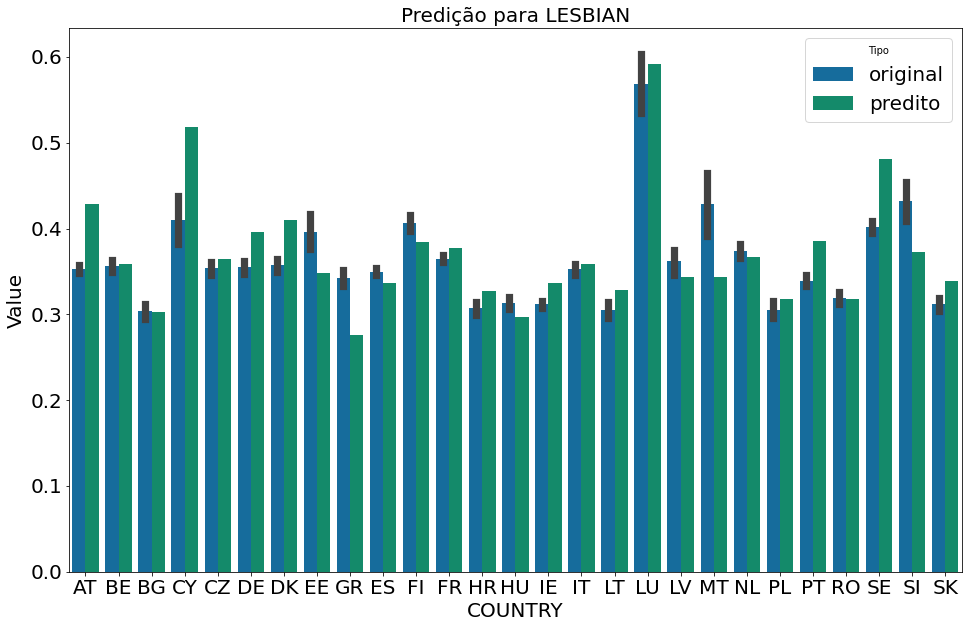

Coeficientes: 
HDI: 0.0120
LEB: -0.0010
EYS: -0.0053
MYS: -0.0155
GNI: -0.0004
GNI_HDI: 0.0007
pdi: 0.0001
idv: 0.0043
mas: -0.0003
uai: -0.0018
ltowvs: 0.0006
ivr: 0.0181
Religiosity: -0.0050
NonAtheist: -0.0109
ReligiousAndAtheists: -0.0001
Mean_squared_error : 0.0003
R_score: 0.7845


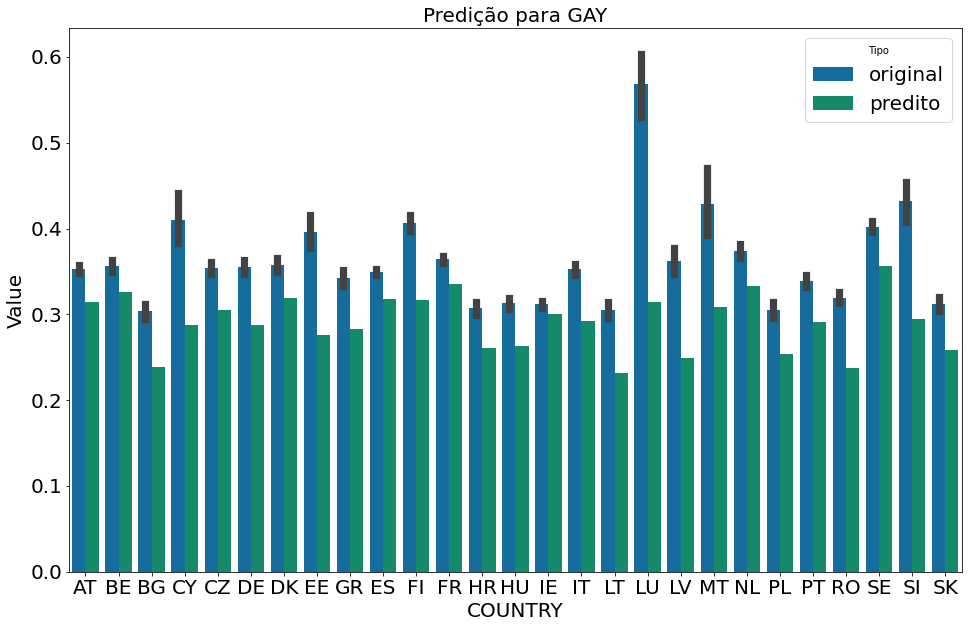

Coeficientes: 
HDI: 0.3743
LEB: -0.1435
EYS: -0.1370
MYS: -0.1500
GNI: -0.1983
GNI_HDI: 0.0192
pdi: -0.0253
idv: 0.0332
mas: -0.0219
uai: -0.0055
ltowvs: 0.0238
ivr: 0.0728
Religiosity: 0.0078
NonAtheist: -0.0189
ReligiousAndAtheists: 0.0251
Mean_squared_error : 0.0016
R_score: 0.5670


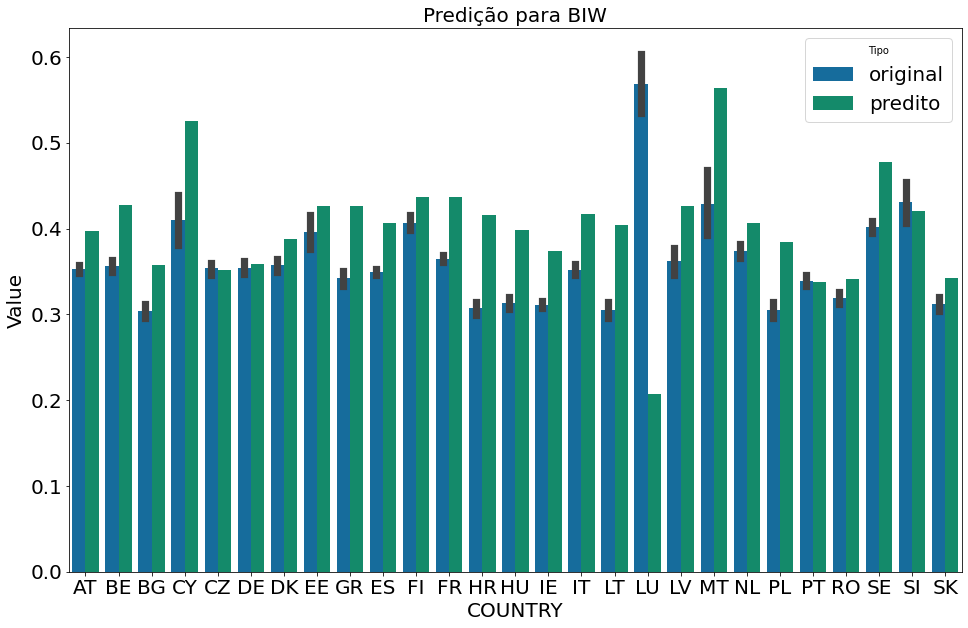

Coeficientes: 
HDI: -0.1775
LEB: 0.1167
EYS: 0.0507
MYS: 0.1328
GNI: 0.1064
GNI_HDI: -0.0551
pdi: -0.0033
idv: -0.0320
mas: -0.0325
uai: 0.0270
ltowvs: -0.0197
ivr: -0.0488
Religiosity: 0.0002
NonAtheist: -0.0023
ReligiousAndAtheists: 0.0019
Mean_squared_error : 0.0043
R_score: 0.5391


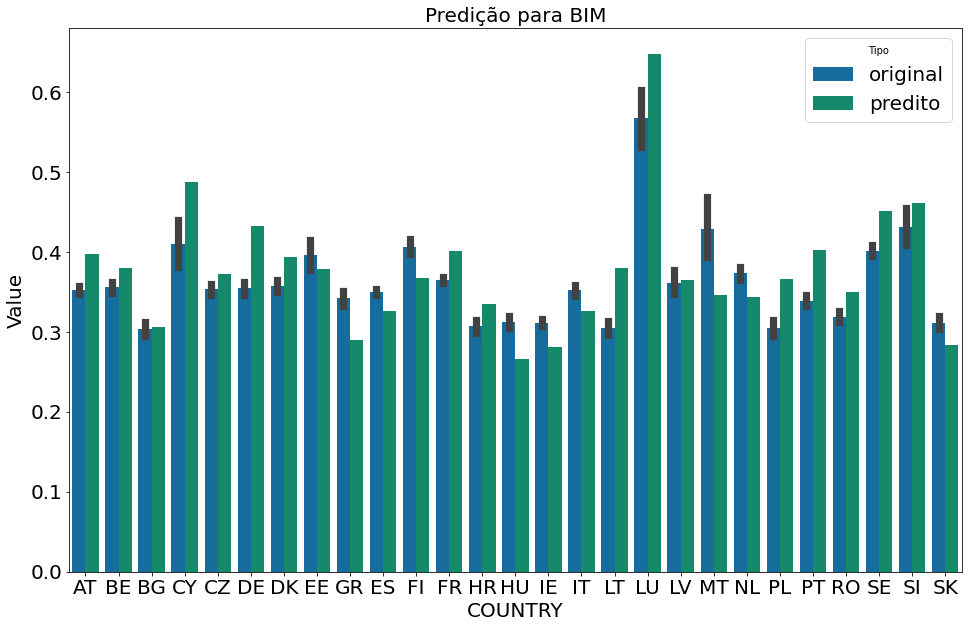

Coeficientes: 
HDI: -0.3458
LEB: 0.2070
EYS: 0.1336
MYS: 0.1755
GNI: 0.1357
GNI_HDI: -0.0649
pdi: 0.0107
idv: -0.0420
mas: -0.0290
uai: 0.0286
ltowvs: -0.0222
ivr: -0.0574
Religiosity: -0.0044
NonAtheist: 0.0032
ReligiousAndAtheists: -0.0092
Mean_squared_error : 0.0024
R_score: 0.4973


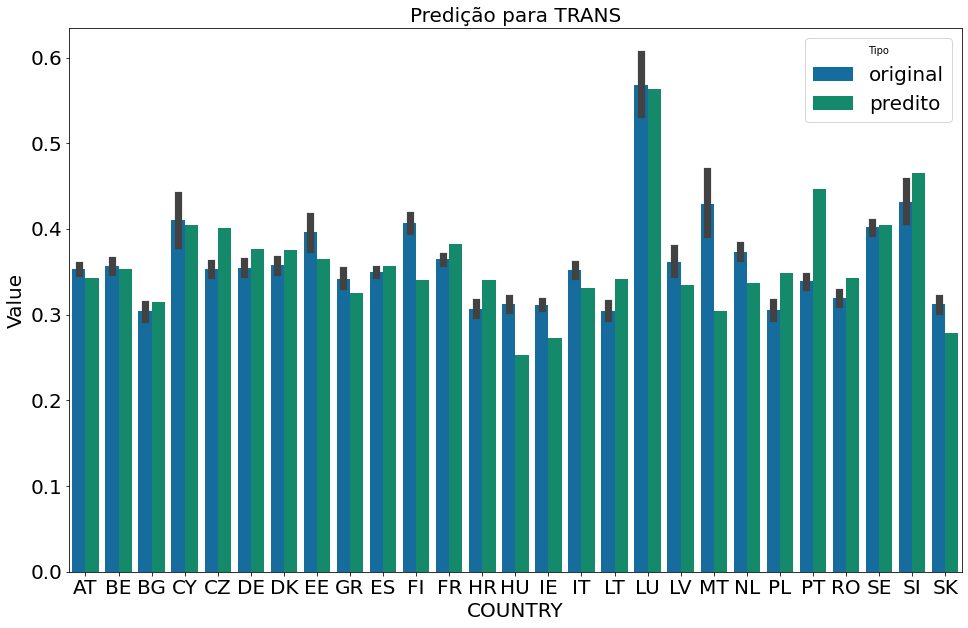

In [167]:
for sub in subset:
    
    a,comp = train(df_final,sub)    
    
    comp = comp.merge(conv)
    
    sns.barplot(data=comp,x="COUNTRY",y="Value",hue= "Tipo")
    plt.title("Predição para {}".format(sub))
    plt.show()